In [38]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator, interpolant
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import time




In [39]:
# Definir a seed
seed = 43
seed2 = 42
seed3 = 42
np.random.seed(seed)

random.seed(seed)


In [40]:
import pandas as pd


def create_interpolation(file_path, decimal=','):

    # Carregar os dados do CSV
    data = pd.read_csv(file_path, decimal=decimal)
    
    
    # Configurar os eixos da malha
    N_rot = np.arange(2e4, 6e4, 1e3)  # De 20000 Hz a 60000 Hz, Shape: (40,)
    Mass = np.arange(3, 21.1, 0.1)   # De 3 a 21, Shape: (181,)
    Phi = data.values                # Valores da tabela, Shape: (40,181)
    
    # Linearizar a matriz Phi para criação da LUT
    phi_flat = Phi.ravel(order='F')
    
    # Criar a LUT usando interpolação b-spline
    lut = interpolant('name', 'bspline', [N_rot, Mass], phi_flat)
    
    return lut

# Caminho para o arquivo CSV
file_path = r"C:\Users\fabio\Downloads\tabela_phi.csv"

# Chamar a função e obter a LUT
interpolation = create_interpolation(file_path)


N_rot_example = 3e4  
Mass_example = 21  
result = interpolation([N_rot_example, Mass_example]) 

# Exibir o resultado
print(f"Interpolação para N_rot={N_rot_example}, Mass={Mass_example}: {result}")

Interpolação para N_rot=30000.0, Mass=21: -2.22029


In [41]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(8000, 9000)  # MPa
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value



class N_generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def N(self):
        while True:
            value = np.random.uniform(27e3, 5e4)  
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value
            




In [42]:
def ale():
  return np.random.uniform(4000, 5000)



p1_gen = P1Generator(seed)
N_gen = N_generator(seed)

In [43]:
def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3   # m²
    L_c = 2.0      # m
    alpha = 0.5   #  
    P_out = 5.0 
    C1 = 479.029  # Constante
    V_p = 2.0    # m³
    K_nu = 0.38   # kg / (kPa^0.5 s)
    phi = 1.5   # φ
    z = 0 if x[1] < P_out else np.sqrt(x[1]*1e3   - P_out*1e3)

    dmdt = (A1 / L_c) * ((phi * 8.5 - x[1]) *1e3)
    dPdt = ((C1**2/V_p) * (x[0] - alpha * K_nu * z )) 

    return dmdt, dPdt

stati = fsolve(Estacionario, [100, 105])

print(Estacionario(stati))

(np.float64(0.0), np.float64(0.0))


In [44]:
def Sistemas(x0, P1_value, interpolant_function, N_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p',2)
    start = time.time()

    #N = p[1]
    phi = interpolant_function(vertcat(p[1], x[0])) 
    
    

    # Constantes
    A1 = 2.6e-3          # m²
    L_c = 2.0            # m
    alpha = 0.5          # Constante Abertura da valvula
    P_out = 5.0          #  kPa
    C1 = 479.029         # Constante Velocidade do Som na Entrada do Compressor 
    V_p = 2.0            # m³
    K_nu = 0.38         # kg / (kBar^0.5 s)
    phi_value = 1.5      # 

    z = if_else(x[1] < P_out, 0, sqrt(x[1]*1000 - P_out*1000))

    rhs = vertcat(
        (A1 / L_c) * (phi * (p[0]/1000) - x[1] )*1000,    # Vazão Massica/ dt
        (C1**2 / V_p) * (x[0] - alpha * K_nu * sqrt(x[1]*1000 - P_out*1000))         # Pressão do Plenum / dt
    ) 

    ode = {'x': x, 'ode': rhs , 'p': p}
    F = integrator('F', 'cvodes', ode, {'tf': 60, "max_step_size": 10})

    #
    t_eval = np.linspace(0, 60, 600)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9

    #
    for i in range(len(t_eval)):
        param = [P1_value, N_value]
        res = F(x0=x0, p=param)
        x_next = res['xf'].full().flatten()
        sol[i] = x_next
        # Update initial state
        x0 = x_next

    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    
    return sol, P1_value,N_value, t_eval



In [45]:
def Loop(loops, stati):
    estados = []
    p1_total = []
    N_total = []
    t_eval_total = []

    for i in range(loops):
        if i == 0:

            x0 = stati  # Estado inicial
        else:
            x0 = estados[-1][-1]

        P1_v = p1_gen.P1()  # Geração aleatória de P1
        N_v = N_gen.N()
        sol, P1_aleatorio,aaaa, t_eval = Sistemas(x0, P1_v, interpolation,N_v)
        estados.append(sol)
        N_total.append(aaaa)
        p1_total.append(P1_aleatorio)
        
        # Concatenar tempo
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, N_total, t_total

Tempo de execução: 0.1661238670349121 segundos
Tempo de execução: 0.10010266304016113 segundos
Tempo de execução: 0.11977243423461914 segundos
Tempo de execução: 0.10339236259460449 segundos
Tempo de execução: 0.11017918586730957 segundos
Tempo de execução: 0.12497138977050781 segundos
Tempo de execução: 0.11471843719482422 segundos
Tempo de execução: 0.1274716854095459 segundos
Tempo de execução: 0.11724305152893066 segundos
Tempo de execução: 0.1678769588470459 segundos
Tempo de execução: 0.34686899185180664 segundos
Tempo de execução: 0.25807762145996094 segundos
Tempo de execução: 0.2418231964111328 segundos
Tempo de execução: 0.16102886199951172 segundos
Tempo de execução: 0.1398301124572754 segundos
Tempo de execução: 0.16933941841125488 segundos
Tempo de execução: 0.1472315788269043 segundos
Tempo de execução: 0.12770557403564453 segundos
Tempo de execução: 0.10921382904052734 segundos
Tempo de execução: 0.11593842506408691 segundos
Tempo de execução: 0.12977194786071777 segundo

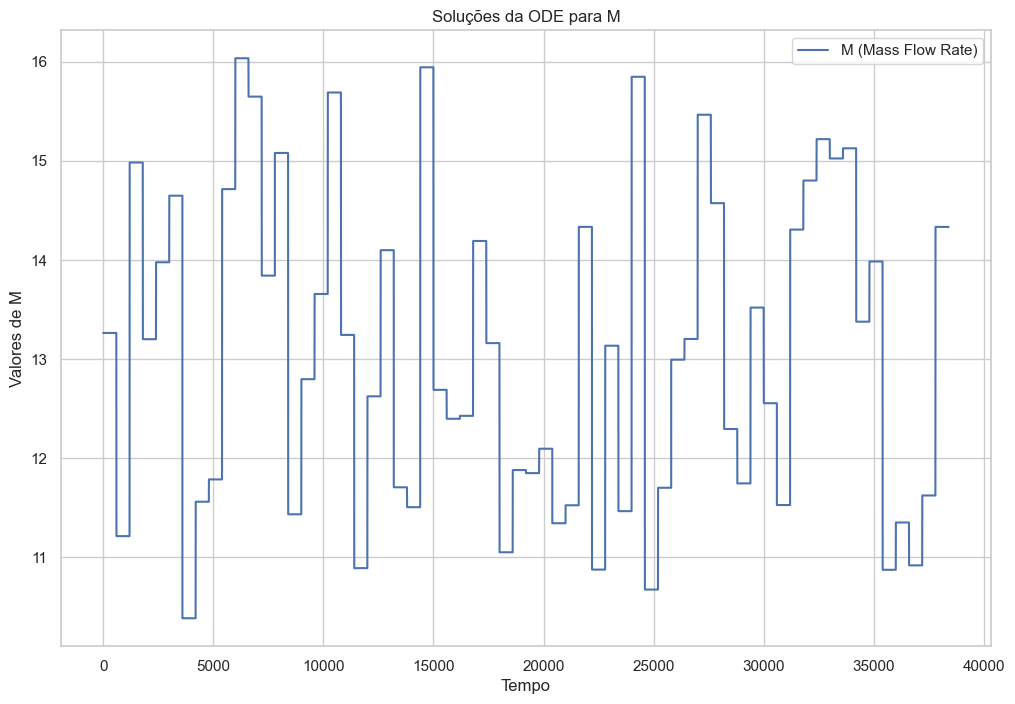

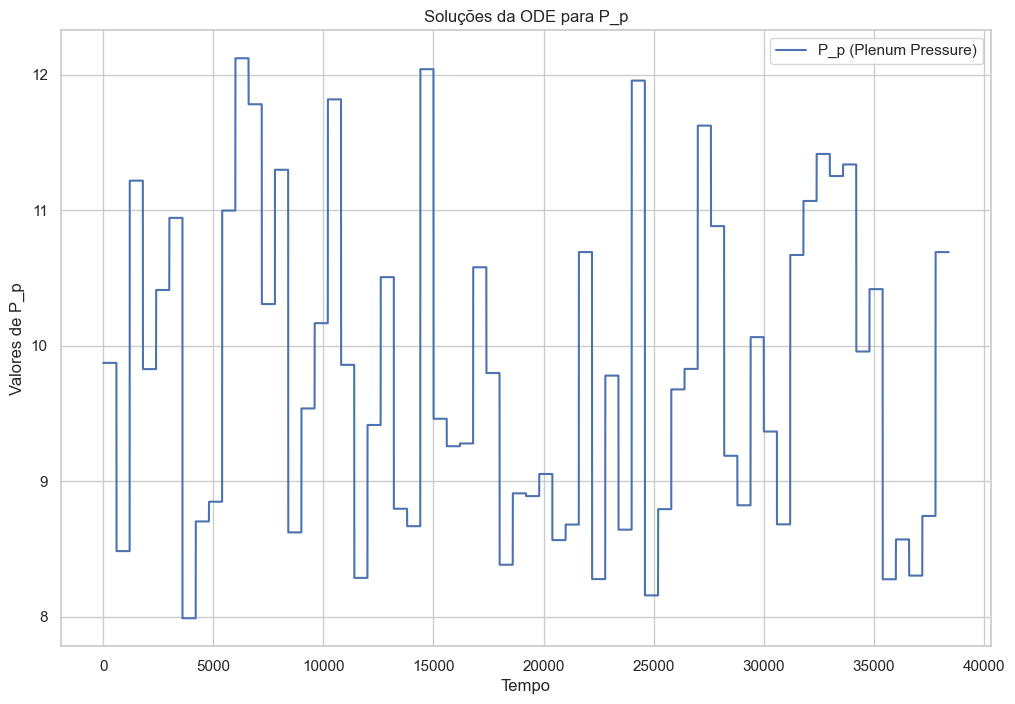

In [46]:

aaaa, PlotP1, PlotN, Plott = Loop(64, stati)
bbb = aaaa
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]

P_p_final = Ploty[:,1]

# Plotar os resultados
plt.figure()
plt.plot(Ploty[:, 0], label='M (Mass Flow Rate)')
plt.xlabel('Tempo')
plt.ylabel('Valores de M')
plt.title('Soluções da ODE para M')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(Ploty[:, 1], label='P_p (Plenum Pressure)')
plt.xlabel('Tempo')
plt.ylabel('Valores de P_p')
plt.title('Soluções da ODE para P_p')
plt.legend()
plt.grid(True)
plt.show()




In [47]:
# Normalização de dados para o intervalo [-1, 1]
def normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = 2 * (Mat_dados[:, i] - min_value) / (max_value - min_value) - 1
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = 2 * (Mat_dados[:] - min_value) / (max_value - min_value) - 1

    return result


# Desnormalização de dados do intervalo [-1, 1] para os valores originais
def des_normalize(Mat_ref, Mat_dados):
    result = np.zeros_like(Mat_dados, dtype=float)
    try:
        for i in range(Mat_ref.shape[1]):
            
            max_value = Mat_ref[:, i].max()
            min_value = Mat_ref[:, i].min()
            result[:, i] = (Mat_dados[:, i] + 1) * (max_value - min_value) / 2 + min_value
    except:
        max_value = Mat_ref[:].max()
        min_value = Mat_ref[:].min()
        result[:] = (Mat_dados[:] + 1) * (max_value - min_value) / 2 + min_value

    return result

In [48]:
# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
N_values = np.array(PlotN)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]

# Garantindo que as repetições sejam suficientes
repeated_P1 = np.repeat(P1_values, -(-len(M[:-1]) // len(P1_values)))[:len(M[:-1])]
repeated_N = np.repeat(N_values, -(-len(M[:-1]) // len(N_values)))[:len(M[:-1])]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], repeated_P1, repeated_N))
y = np.column_stack((M[1:], P_p[1:]))

split_index = len(X) // 2

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]




In [49]:
from matplotlib.pyplot import scatter, figure

In [50]:

X_test_ref = X_test
y_test_ref = y_test
X_train = normalize(X_train,X_train)
X_test =   normalize(X_test,X_test)
y_train = normalize(y_train,y_train)
y_test =   normalize(y_test,y_test)

# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1) # Adiciona dimensão de sequência
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        # LSTM bidirecional
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = nn.Tanh()
        
        # Camadas lineares
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # 2 * hidden_dim por ser bidirecional
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim//2, 2)  # Saída intermediária para entrada em mu e var
        
        # Camadas para estimativa de média (mu) e variância (var)
        self.mu = nn.Linear(2, output_dim)
        self.var = nn.Linear(2, output_dim)

    def forward(self, x):
        # Processamento através da LSTM
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.transpose(0, 1).reshape(-1, h_n.size(2) * 2)  # Concatenar saídas bidirecionais
        
        # Passagem pelas camadas lineares com dropout
        x = self.dropout(h_n)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        
        # Estimar média (mu) e variância (var)
        mu = self.mu(x)
        var = torch.exp(self.var(x))  
        
        return mu,  var

    

    

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize': (12, 8)}, style='whitegrid')

def make_plot(model, X_test_tensor, y_test):
    # Obter as previsões
    with torch.no_grad():
        mu, var = model(X_test_tensor)
        mu = mu.numpy()
        var =var.numpy()
        sigma = np.sqrt(var)

    # Gerar intervalos de confiança (~90%)
    upper_bound = mu + 1.96 * var
    lower_bound = mu - 1.96 * var
    

    # Preparar os dados para o DataFrame
    plot_data = {
        'Índice': range(len(y_test)),
        'Valor Real': y_test[:, 0],  # Primeiro parâmetro do target
        'Previsão': mu[:, 0],       # Previsão correspondente
        'Limite Superior': upper_bound[:, 0],
        'Limite Inferior': lower_bound[:, 0]
    }

    df = pd.DataFrame(plot_data)

    # Plotar os dados
    plt.figure(figsize=(14, 8))
    plt.plot(df['Índice'], df['Valor Real'], label='Valor Real', color='blue', linestyle='-', linewidth=1.5)
    plt.plot(df['Índice'], df['Previsão'], label='Previsão', color='orange', linestyle='--', linewidth=1.5)
    plt.fill_between(
        df['Índice'],
        df['Limite Inferior'],
        df['Limite Superior'],
        color='orange',
        alpha=0.2,
        label='Intervalo de Confiança (95%)'
    )


    # Personalizar o gráfico
    plt.title('Previsões com Intervalos de Confiança', fontsize=16)
    plt.xlabel('Índice', fontsize=14)
    plt.ylabel('Valores', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()






In [110]:
input_dim = X_train_tensor.shape[2]
output_dim = y_train_tensor.shape[1]
batch_size = 32
n_epochs = 150




train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [112]:
import optuna 
from optuna.trial import TrialState

def objective(trial):
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    hidden_dim = trial.suggest_int("hidden_dim", 100, 130)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
    criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred, var = model(X_batch)
            loss = criterion(y_pred, y_batch, var)
            loss.backward()
            optimizer.step()

    return loss.item()



# Rodar a otimização com Optuna
study = optuna.create_study(direction='minimize') # sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize



[I 2024-12-02 13:53:20,589] A new study created in memory with name: no-name-5b113d81-10bd-4ebb-88ca-4649f6407028


<bound method Study.optimize of <optuna.study.study.Study object at 0x00000253C7F8D3D0>>

In [ ]:

study.optimize(objective, n_trials=10)

# Imprimir o melhor conjunto de hiperparâmetros
print(study.best_params)

[I 2024-12-02 14:11:06,697] Trial 0 finished with value: -2.289393901824951 and parameters: {'dropout_rate': 0.11732591492515124, 'hidden_dim': 104, 'learning_rate': 0.00020464088119670598}. Best is trial 0 with value: -2.289393901824951.
[I 2024-12-02 14:32:01,808] Trial 1 finished with value: -2.2827203273773193 and parameters: {'dropout_rate': 0.23915421384188848, 'hidden_dim': 101, 'learning_rate': 0.004271267212355143}. Best is trial 0 with value: -2.289393901824951.
[I 2024-12-02 14:57:42,624] Trial 2 finished with value: -2.2984845638275146 and parameters: {'dropout_rate': 0.10815952591629255, 'hidden_dim': 118, 'learning_rate': 0.003026424736997684}. Best is trial 2 with value: -2.2984845638275146.
[I 2024-12-02 15:27:48,045] Trial 3 finished with value: -2.2922897338867188 and parameters: {'dropout_rate': 0.46053803871760257, 'hidden_dim': 114, 'learning_rate': 0.005520102899089879}. Best is trial 2 with value: -2.2984845638275146.
[I 2024-12-02 15:57:18,559] Trial 4 finished 

In [56]:
best_params = study.best_params
# Definir parâmetros do modelo
hidden_dim = best_params['hidden_dim']
dropout_rate =  best_params['dropout_rate']
learning_rate = best_params['learning_rate']

# Inicializar o modelo, função de perda e otimizador
model = LSTMModel(input_dim, hidden_dim, output_dim, dropout_rate)
criterion = torch.nn.GaussianNLLLoss(eps=1e-02) 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.eval()
print(best_params)

{'dropout_rate': 0.3394633936788146, 'hidden_dim': 104, 'learning_rate': 0.00020511104188433984}


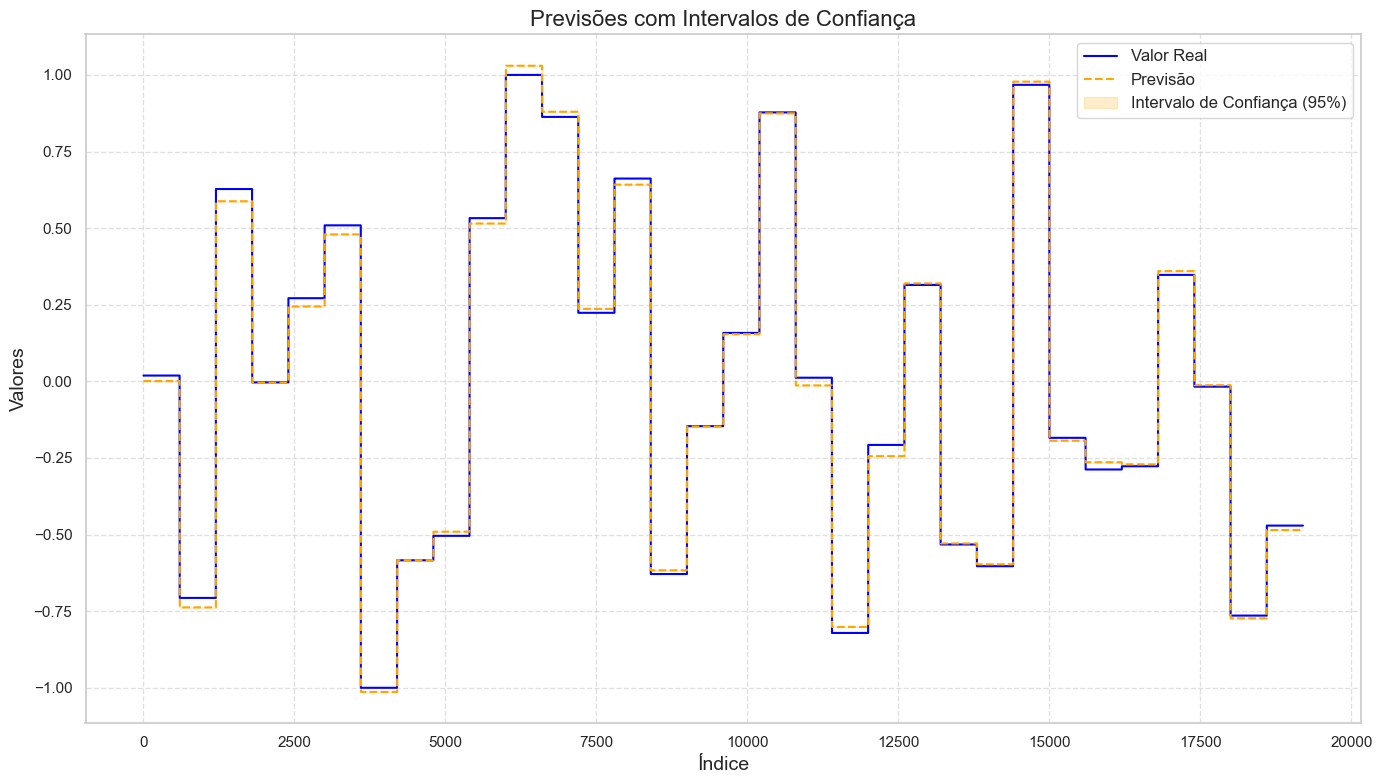

BEST MODEL
Epoch 0 | Train Loss: -2.2591660022735596 | Test Loss: -2.1014946711063387 | Variance: 1.0697775131018883e-12
BEST MODEL
Epoch 1 | Train Loss: -2.270968437194824 | Test Loss: -2.1014946711063387 | Variance: 1.075860320970401e-12
Epoch 2 | Train Loss: -2.2858450412750244 | Test Loss: -2.1014946711063387 | Variance: 1.065617212525627e-12
Epoch 3 | Train Loss: -2.2977840900421143 | Test Loss: -2.1014946711063387 | Variance: 8.755487112231675e-13
Epoch 4 | Train Loss: -2.297870635986328 | Test Loss: -2.1014946711063387 | Variance: 8.857666119674312e-13
Epoch 5 | Train Loss: -2.299654245376587 | Test Loss: -2.1014946711063387 | Variance: 9.550757537266086e-13
Epoch 6 | Train Loss: -2.299819231033325 | Test Loss: -2.1014946711063387 | Variance: 1.009905809153111e-12
Epoch 7 | Train Loss: -2.299031972885132 | Test Loss: -2.1014946711063387 | Variance: 1.0198252832493981e-12
Epoch 8 | Train Loss: -2.2994797229766846 | Test Loss: -2.1014946711063387 | Variance: 9.92390197795956e-13
E

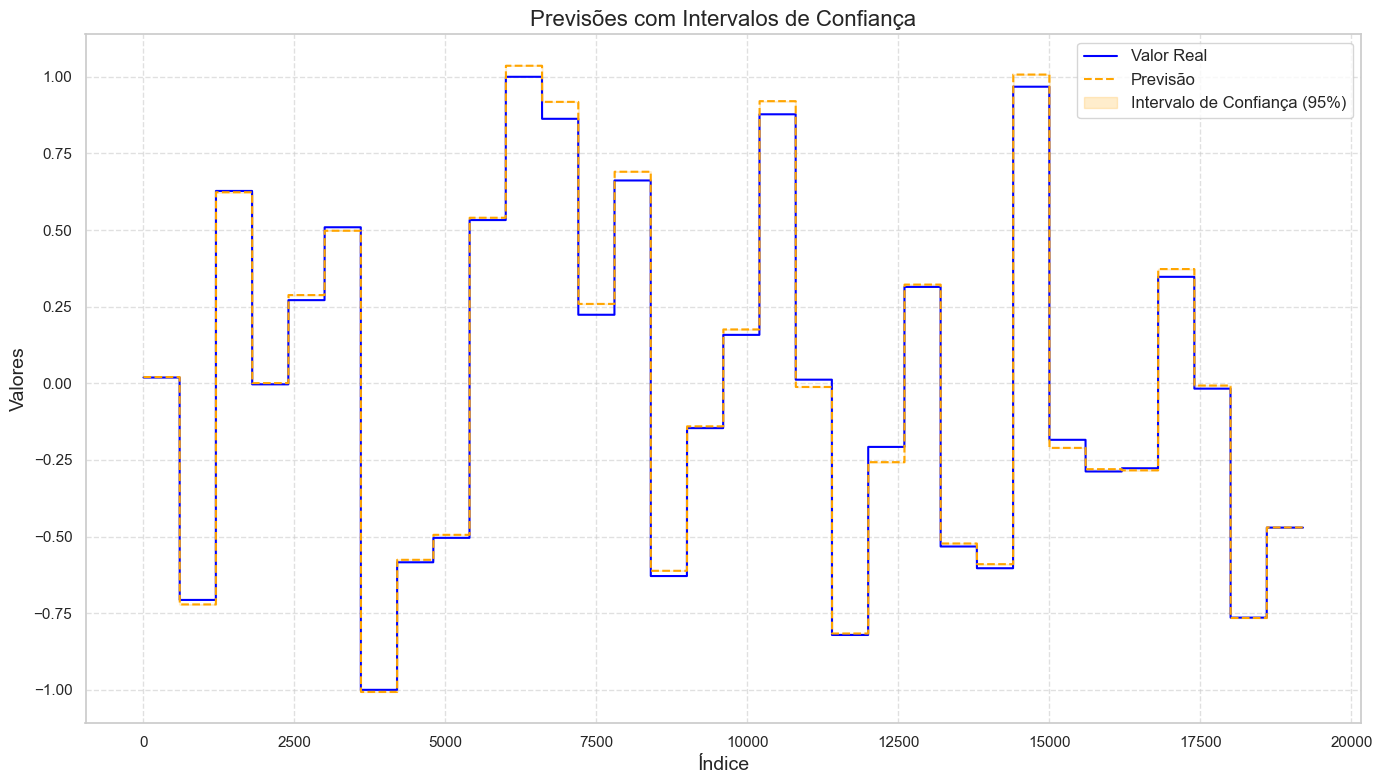

Epoch 10 | Train Loss: -2.299466133117676 | Test Loss: -2.0866333091259004 | Variance: 1.0265374704790386e-12
Epoch 11 | Train Loss: -2.2977371215820312 | Test Loss: -2.0866333091259004 | Variance: 8.064239380434213e-13
Epoch 12 | Train Loss: -2.2993738651275635 | Test Loss: -2.0866333091259004 | Variance: 7.822898145243284e-13
Epoch 13 | Train Loss: -2.3019063472747803 | Test Loss: -2.0866333091259004 | Variance: 9.064406126732538e-13
BEST MODEL
Epoch 14 | Train Loss: -2.297999382019043 | Test Loss: -2.0866333091259004 | Variance: 8.167799119343511e-13
BEST MODEL
Epoch 15 | Train Loss: -2.300469398498535 | Test Loss: -2.0866333091259004 | Variance: 7.660712342261178e-13
Epoch 16 | Train Loss: -2.297910213470459 | Test Loss: -2.0866333091259004 | Variance: 7.118801533499697e-13
Epoch 17 | Train Loss: -2.2853047847747803 | Test Loss: -2.0866333091259004 | Variance: 6.815459654974099e-13
Epoch 18 | Train Loss: -2.2521164417266846 | Test Loss: -2.0866333091259004 | Variance: 9.63696136779

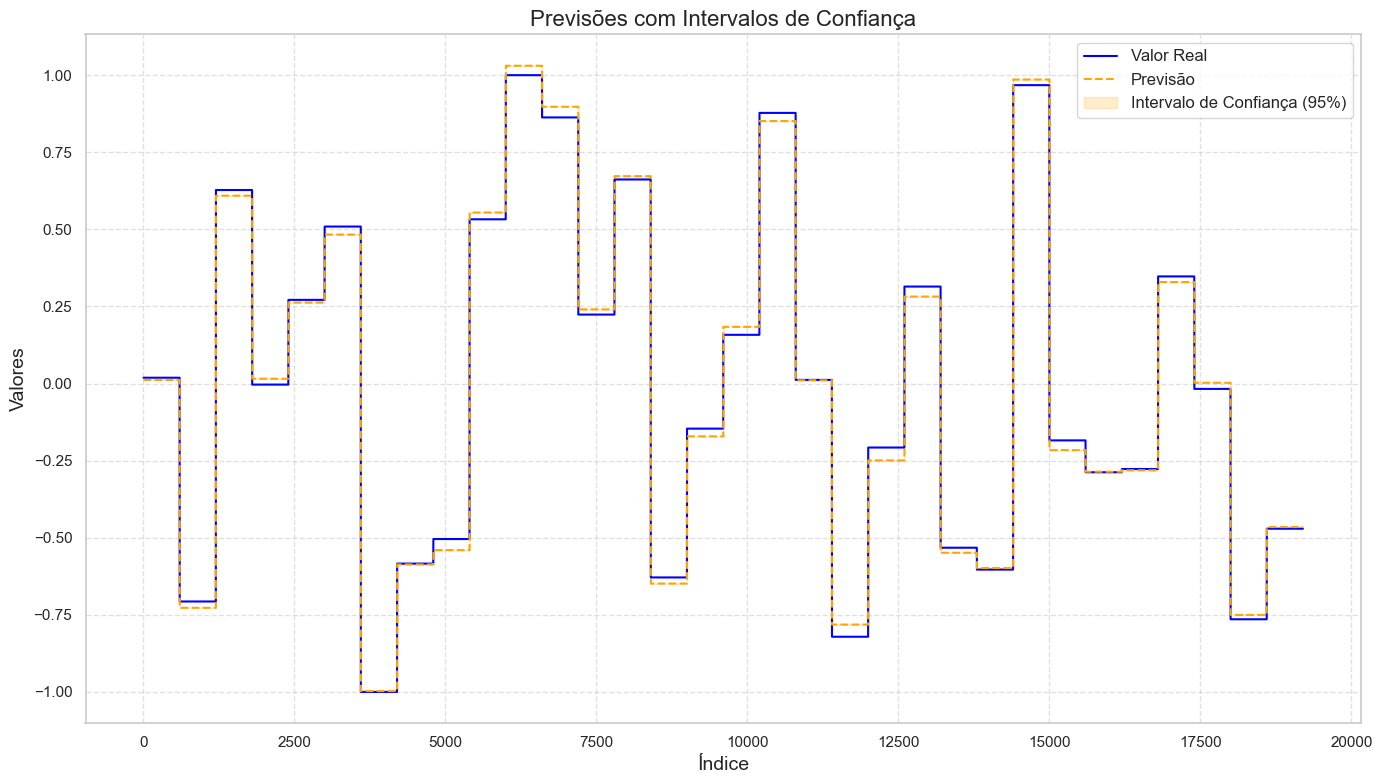

Epoch 20 | Train Loss: -2.2993276119232178 | Test Loss: -2.054463220834732 | Variance: 2.094941407848605e-12
Epoch 21 | Train Loss: -2.1852939128875732 | Test Loss: -2.054463220834732 | Variance: 1.8835204663308902e-12
Epoch 22 | Train Loss: -2.277523994445801 | Test Loss: -2.054463220834732 | Variance: 1.5772409420189426e-12
Epoch 23 | Train Loss: -2.29130220413208 | Test Loss: -2.054463220834732 | Variance: 1.471563973107215e-12
BEST MODEL
Epoch 24 | Train Loss: -2.298403263092041 | Test Loss: -2.054463220834732 | Variance: 1.4192657465939007e-12
Epoch 25 | Train Loss: -2.296297311782837 | Test Loss: -2.054463220834732 | Variance: 1.37742855316203e-12
Epoch 26 | Train Loss: -2.2963521480560303 | Test Loss: -2.054463220834732 | Variance: 1.4402034252680718e-12
Epoch 27 | Train Loss: -2.2978744506835938 | Test Loss: -2.054463220834732 | Variance: 1.425564310694738e-12
Epoch 28 | Train Loss: -2.28401780128479 | Test Loss: -2.054463220834732 | Variance: 1.1462958403665735e-12
Epoch 29 | 

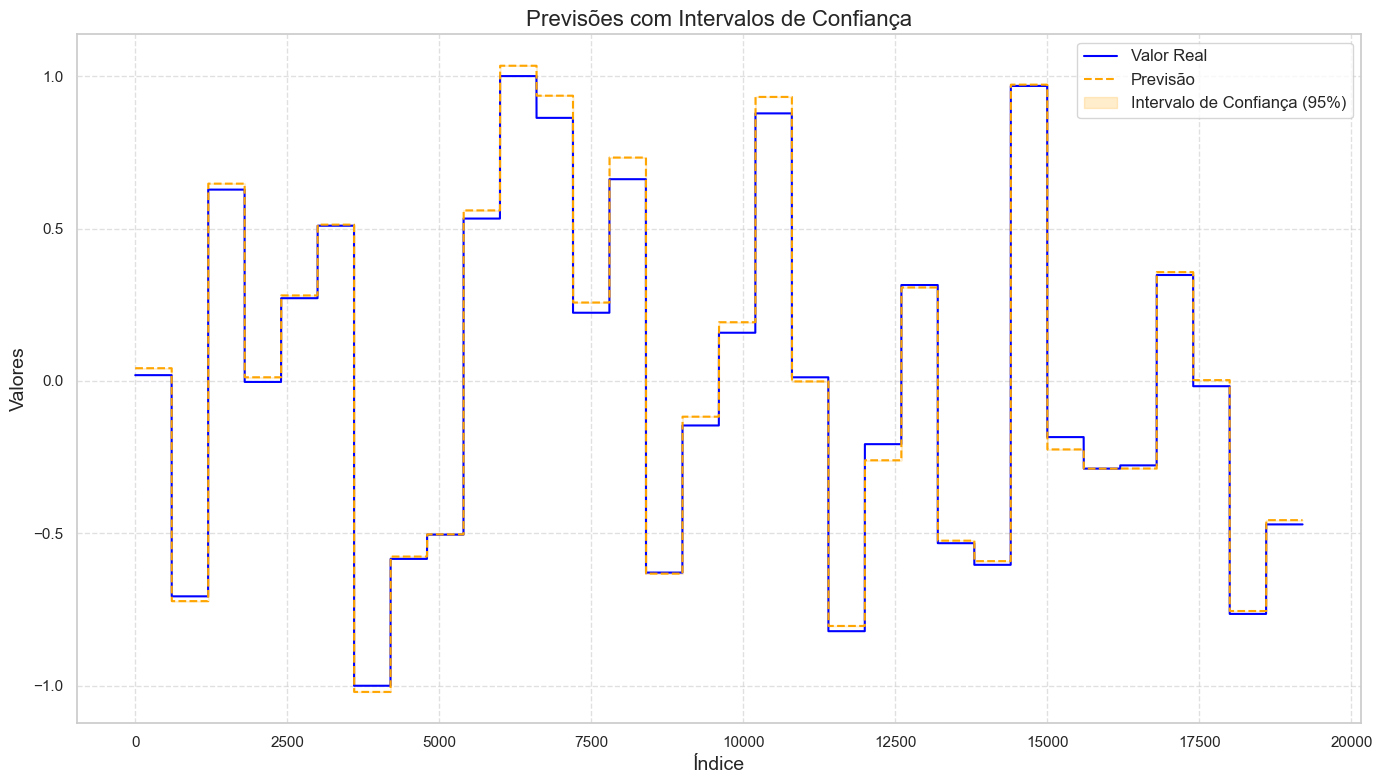

Epoch 30 | Train Loss: -2.289811134338379 | Test Loss: -2.0292529296875 | Variance: 2.1780318434222457e-12
Epoch 31 | Train Loss: -2.3013336658477783 | Test Loss: -2.0292529296875 | Variance: 2.2429072488172608e-12
Epoch 32 | Train Loss: -2.295626163482666 | Test Loss: -2.0292529296875 | Variance: 1.173538696774834e-12
Epoch 33 | Train Loss: -2.2940170764923096 | Test Loss: -2.0292529296875 | Variance: 1.3621157153587138e-12
Epoch 34 | Train Loss: -2.238609552383423 | Test Loss: -2.0292529296875 | Variance: 1.3879936696520323e-12
BEST MODEL
Epoch 35 | Train Loss: -2.3015010356903076 | Test Loss: -2.0292529296875 | Variance: 1.3818909124635459e-12
Epoch 36 | Train Loss: -2.2981343269348145 | Test Loss: -2.0292529296875 | Variance: 1.5320049916167644e-12
Epoch 37 | Train Loss: -2.2991578578948975 | Test Loss: -2.0292529296875 | Variance: 1.2881181581450574e-12
BEST MODEL
Epoch 38 | Train Loss: -2.287187099456787 | Test Loss: -2.0292529296875 | Variance: 1.3651516982821077e-12
Epoch 39 | 

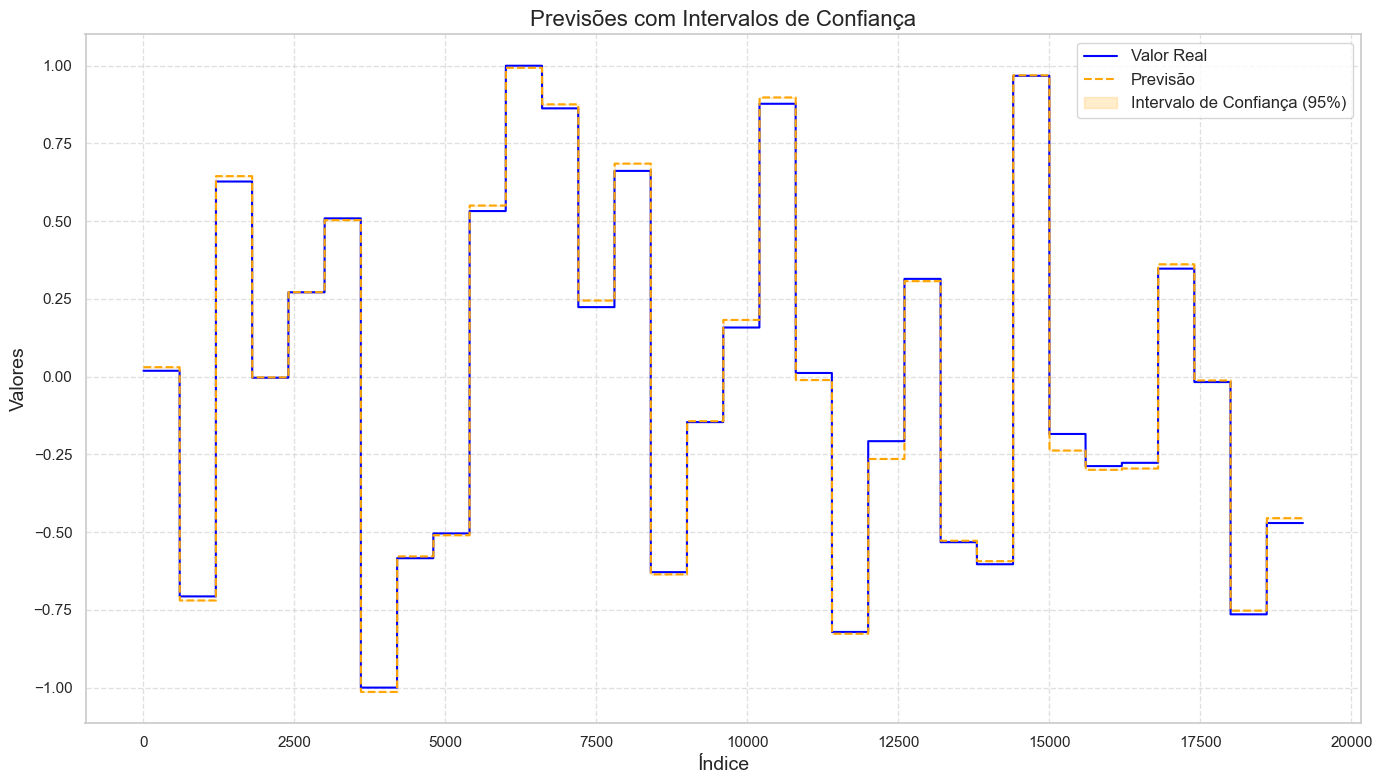

Epoch 40 | Train Loss: -2.2776591777801514 | Test Loss: -2.1206224008401233 | Variance: 1.211705323751755e-12
Epoch 41 | Train Loss: -2.302114248275757 | Test Loss: -2.1206224008401233 | Variance: 1.0953233762697745e-12
Epoch 42 | Train Loss: -2.2961549758911133 | Test Loss: -2.1206224008401233 | Variance: 1.292489661304519e-12
Epoch 43 | Train Loss: -2.302156686782837 | Test Loss: -2.1206224008401233 | Variance: 1.6011091107451247e-12
Epoch 44 | Train Loss: -2.300503969192505 | Test Loss: -2.1206224008401233 | Variance: 1.2329794303600483e-12
Epoch 45 | Train Loss: -2.2270400524139404 | Test Loss: -2.1206224008401233 | Variance: 1.120721029000682e-12
Epoch 46 | Train Loss: -2.279742956161499 | Test Loss: -2.1206224008401233 | Variance: 9.464754284135846e-13
Epoch 47 | Train Loss: -2.301539182662964 | Test Loss: -2.1206224008401233 | Variance: 1.0385650672795066e-12
Epoch 48 | Train Loss: -2.2643582820892334 | Test Loss: -2.1206224008401233 | Variance: 9.552937867834954e-13
Epoch 49 | 

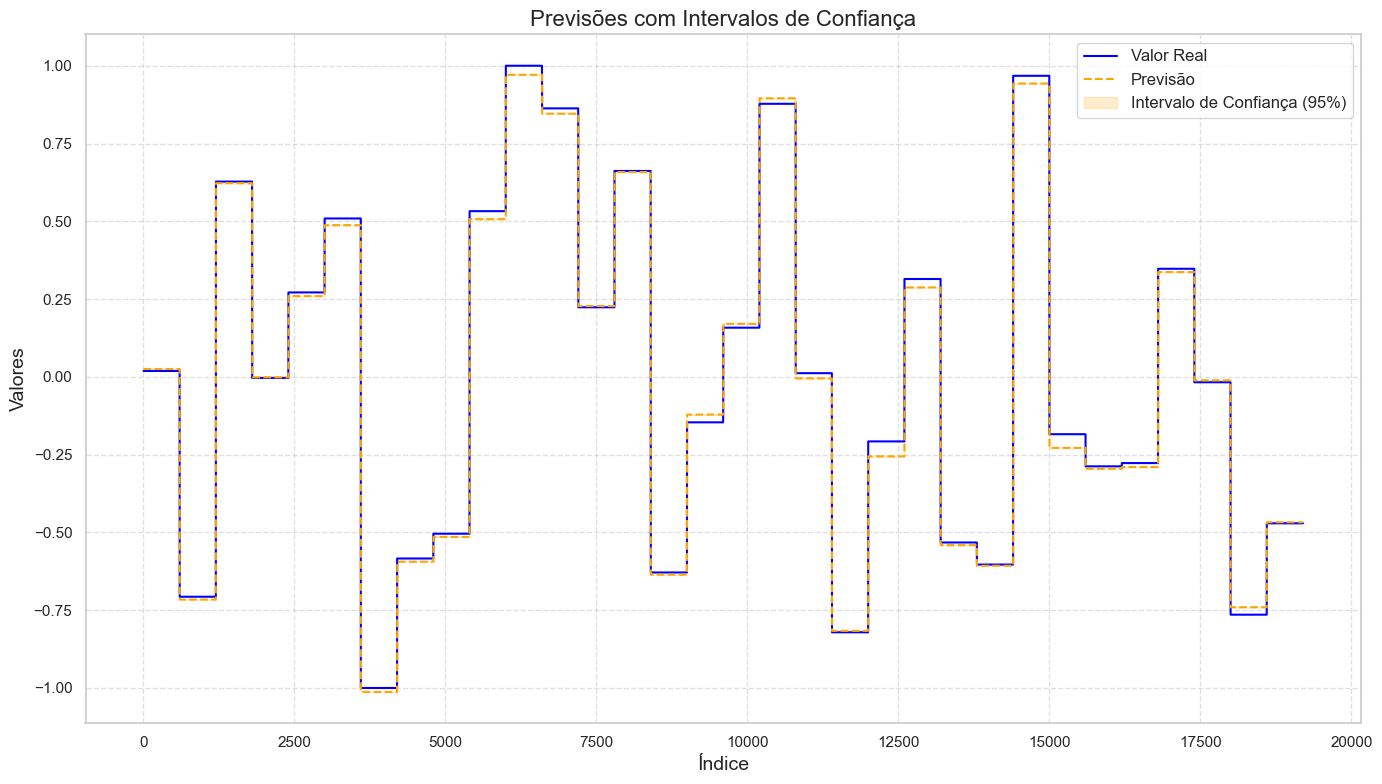

Epoch 50 | Train Loss: -2.302449941635132 | Test Loss: -2.1208215574423472 | Variance: 8.939819370890056e-13
Epoch 51 | Train Loss: -2.3010854721069336 | Test Loss: -2.1208215574423472 | Variance: 9.298511396624298e-13
Epoch 52 | Train Loss: -2.2957003116607666 | Test Loss: -2.1208215574423472 | Variance: 7.020957166342656e-13
Epoch 53 | Train Loss: -2.271517276763916 | Test Loss: -2.1208215574423472 | Variance: 6.660355860582667e-13
Epoch 54 | Train Loss: -2.298933982849121 | Test Loss: -2.1208215574423472 | Variance: 6.226978568196762e-13
Epoch 55 | Train Loss: -2.2995970249176025 | Test Loss: -2.1208215574423472 | Variance: 7.516530800555365e-13
Epoch 56 | Train Loss: -2.28267502784729 | Test Loss: -2.1208215574423472 | Variance: 2.261899001432255e-12
Epoch 57 | Train Loss: -2.2167701721191406 | Test Loss: -2.1208215574423472 | Variance: 1.485811040174978e-12
Epoch 58 | Train Loss: -2.1792502403259277 | Test Loss: -2.1208215574423472 | Variance: 9.853564362019562e-13
Epoch 59 | Trai

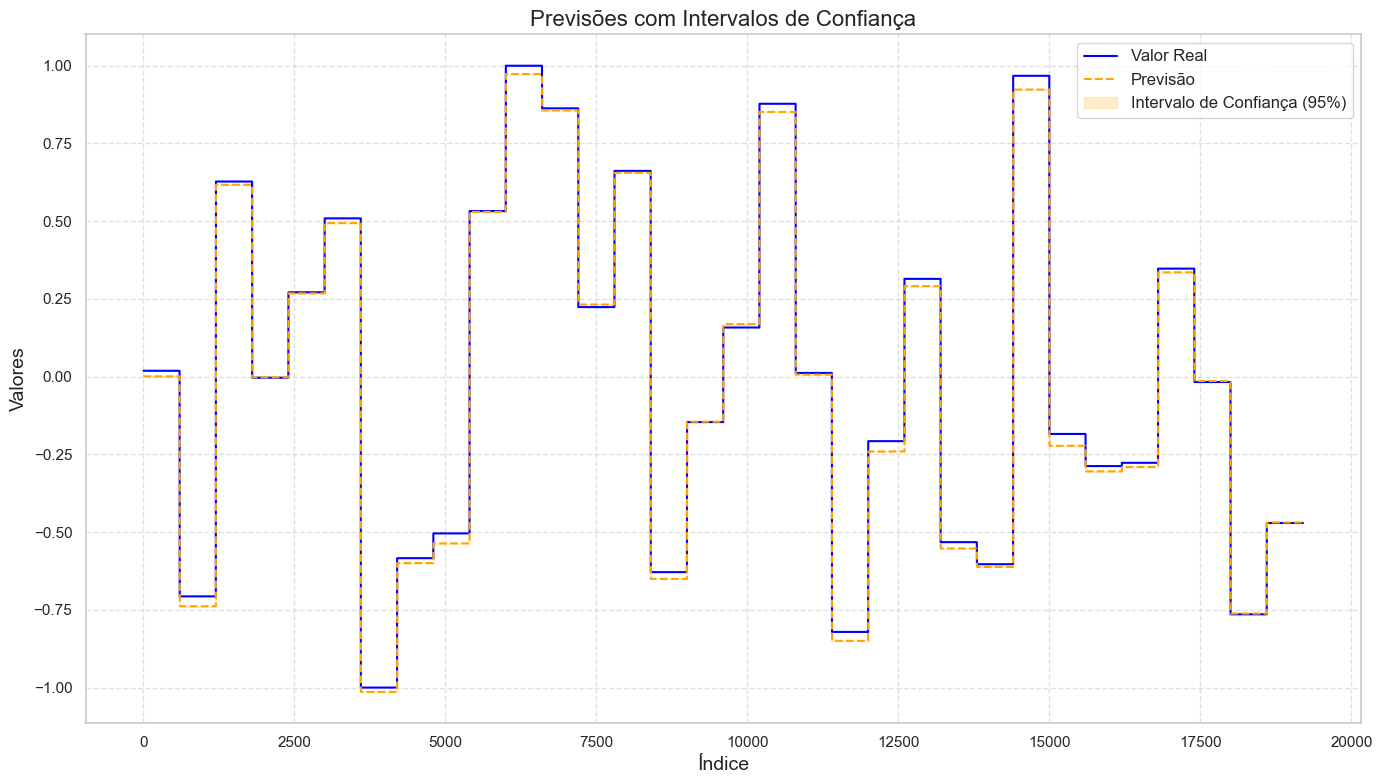

Epoch 60 | Train Loss: -2.3024401664733887 | Test Loss: -2.1627577265103657 | Variance: 8.292982728481946e-13
BEST MODEL
Epoch 61 | Train Loss: -2.3025782108306885 | Test Loss: -2.1627577265103657 | Variance: 7.814569846255337e-13
BEST MODEL
Epoch 62 | Train Loss: -2.2974183559417725 | Test Loss: -2.1627577265103657 | Variance: 8.911101565846347e-13
Epoch 63 | Train Loss: -2.286741018295288 | Test Loss: -2.1627577265103657 | Variance: 1.0004242443142908e-12
BEST MODEL
Epoch 64 | Train Loss: -2.2665462493896484 | Test Loss: -2.1627577265103657 | Variance: 9.458367249137734e-13
BEST MODEL
Epoch 65 | Train Loss: -2.261706590652466 | Test Loss: -2.1627577265103657 | Variance: 9.422019371305157e-13
BEST MODEL
Epoch 66 | Train Loss: -2.25551176071167 | Test Loss: -2.1627577265103657 | Variance: 7.17925502033423e-13
Epoch 67 | Train Loss: -2.3022890090942383 | Test Loss: -2.1627577265103657 | Variance: 6.004003717807738e-13
Epoch 68 | Train Loss: -2.300511598587036 | Test Loss: -2.16275772651

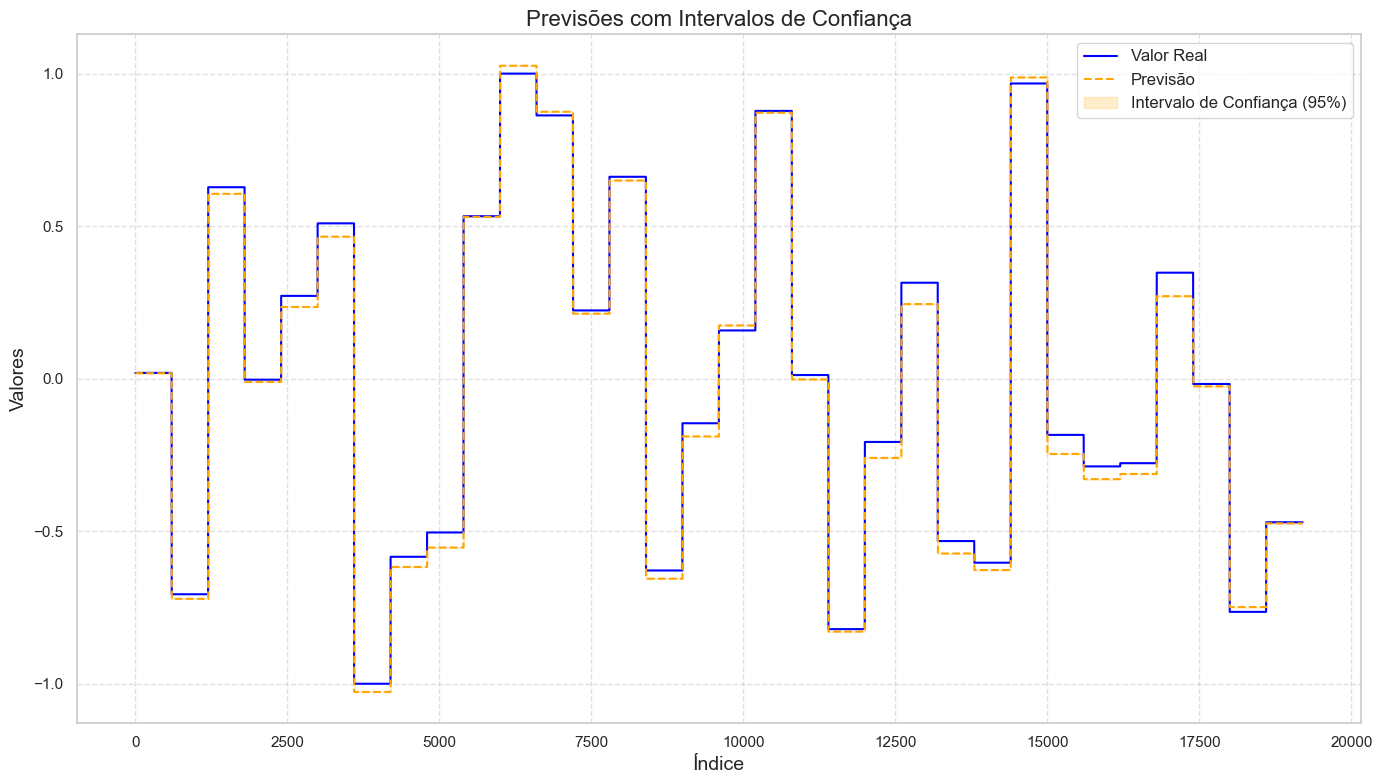

Epoch 70 | Train Loss: -2.297664165496826 | Test Loss: -2.1084170866012575 | Variance: 1.391927263554027e-12
Epoch 71 | Train Loss: -2.2951560020446777 | Test Loss: -2.1084170866012575 | Variance: 8.159216032845029e-13
Epoch 72 | Train Loss: -2.2539427280426025 | Test Loss: -2.1084170866012575 | Variance: 6.919325138896038e-13
Epoch 73 | Train Loss: -2.295192003250122 | Test Loss: -2.1084170866012575 | Variance: 5.34827607548416e-13
Epoch 74 | Train Loss: -2.26106333732605 | Test Loss: -2.1084170866012575 | Variance: 5.505098872420067e-13
Epoch 75 | Train Loss: -2.2718238830566406 | Test Loss: -2.1084170866012575 | Variance: 5.21770994466042e-13
Epoch 76 | Train Loss: -2.300977945327759 | Test Loss: -2.1084170866012575 | Variance: 5.657854827006981e-13
Epoch 77 | Train Loss: -2.3022961616516113 | Test Loss: -2.1084170866012575 | Variance: 5.417716514126425e-13
Epoch 78 | Train Loss: -2.2916572093963623 | Test Loss: -2.1084170866012575 | Variance: 5.786430362642037e-13
Epoch 79 | Train 

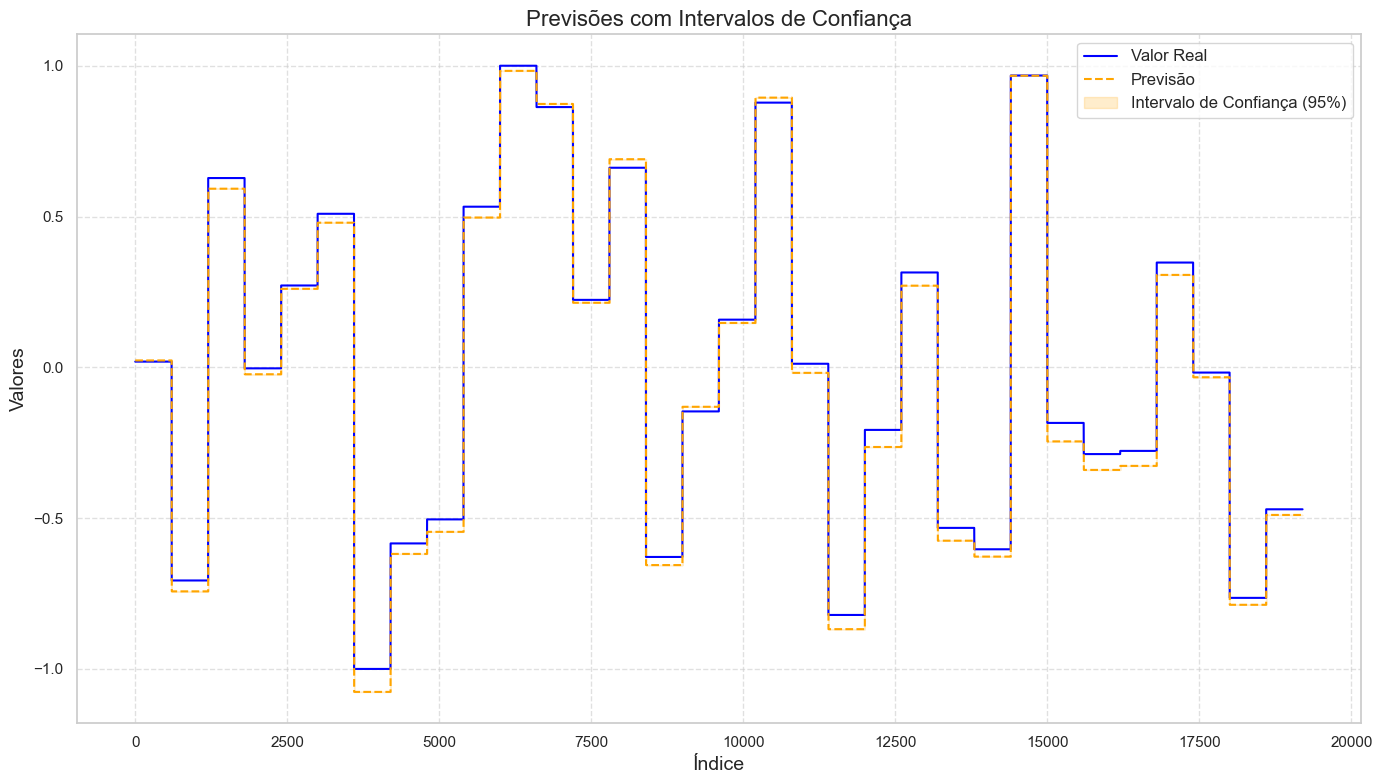

Epoch 80 | Train Loss: -2.241846799850464 | Test Loss: -2.1796429165204367 | Variance: 5.330192125348188e-13
Epoch 81 | Train Loss: -2.1658360958099365 | Test Loss: -2.1796429165204367 | Variance: 9.31875670379112e-13
Epoch 82 | Train Loss: -2.2355284690856934 | Test Loss: -2.1796429165204367 | Variance: 2.413947947782491e-13
Epoch 83 | Train Loss: -2.257197380065918 | Test Loss: -2.1796429165204367 | Variance: 7.988614110499004e-13
Epoch 84 | Train Loss: -2.302492380142212 | Test Loss: -2.1796429165204367 | Variance: 6.93967995048228e-13
Epoch 85 | Train Loss: -2.294527292251587 | Test Loss: -2.1796429165204367 | Variance: 5.443401263592607e-13
Epoch 86 | Train Loss: -2.296863317489624 | Test Loss: -2.1796429165204367 | Variance: 4.652051313613903e-13
Epoch 87 | Train Loss: -2.3004376888275146 | Test Loss: -2.1796429165204367 | Variance: 4.319858002126836e-13
Epoch 88 | Train Loss: -2.301837682723999 | Test Loss: -2.1796429165204367 | Variance: 4.169292406978886e-13
Epoch 89 | Train L

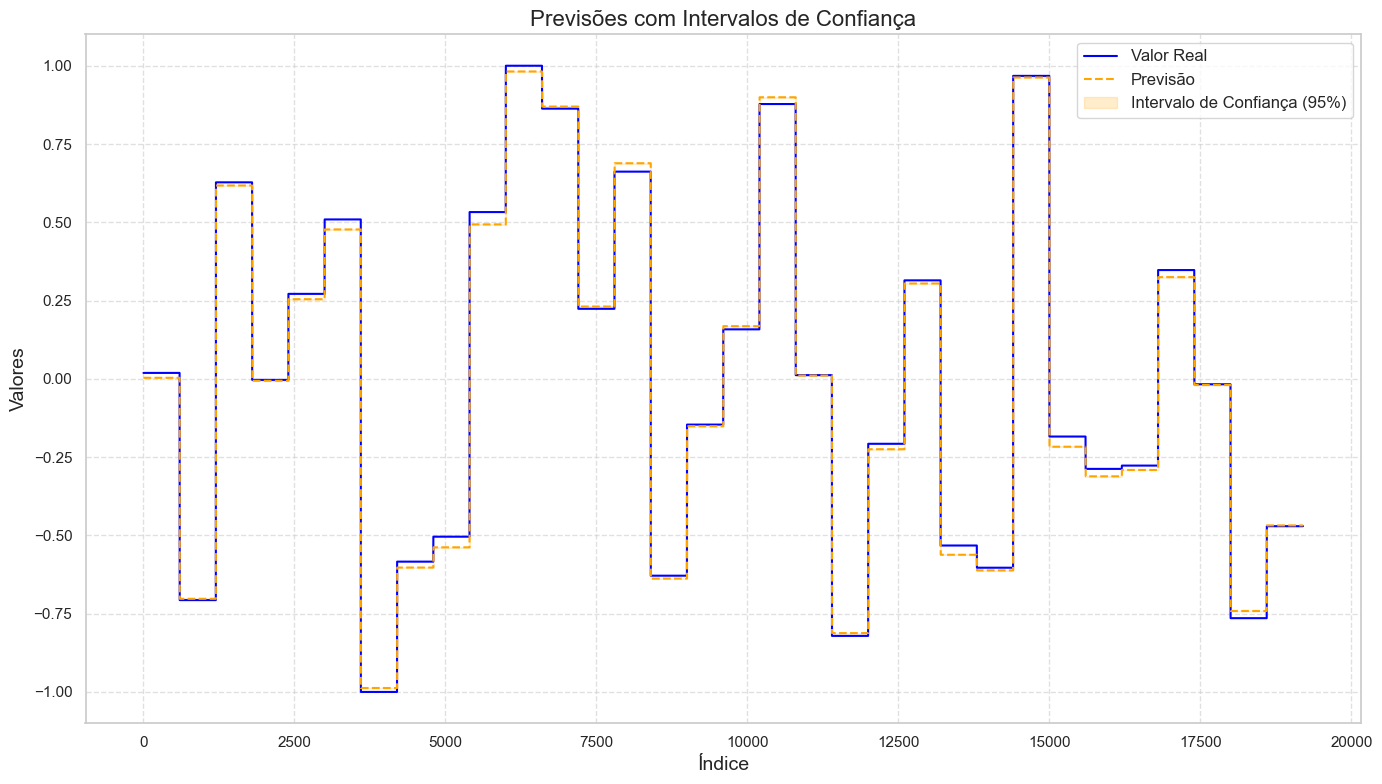

Epoch 90 | Train Loss: -2.3008029460906982 | Test Loss: -2.1621714198589324 | Variance: 4.129745048535305e-13
Epoch 91 | Train Loss: -2.298060178756714 | Test Loss: -2.1621714198589324 | Variance: 3.5218906241883674e-13
Epoch 92 | Train Loss: -2.2616381645202637 | Test Loss: -2.1621714198589324 | Variance: 2.857079807114249e-13
Epoch 93 | Train Loss: -2.1975231170654297 | Test Loss: -2.1621714198589324 | Variance: 2.564991405037964e-13
Epoch 94 | Train Loss: -2.301312208175659 | Test Loss: -2.1621714198589324 | Variance: 3.429320900600469e-13
Epoch 95 | Train Loss: -2.2982842922210693 | Test Loss: -2.1621714198589324 | Variance: 4.957262356684866e-13
Epoch 96 | Train Loss: -2.2908170223236084 | Test Loss: -2.1621714198589324 | Variance: 7.594806402701215e-13
Epoch 97 | Train Loss: -2.227177619934082 | Test Loss: -2.1621714198589324 | Variance: 6.157212868902751e-13
Epoch 98 | Train Loss: -2.268035888671875 | Test Loss: -2.1621714198589324 | Variance: 6.87480671349161e-13
Epoch 99 | Tra

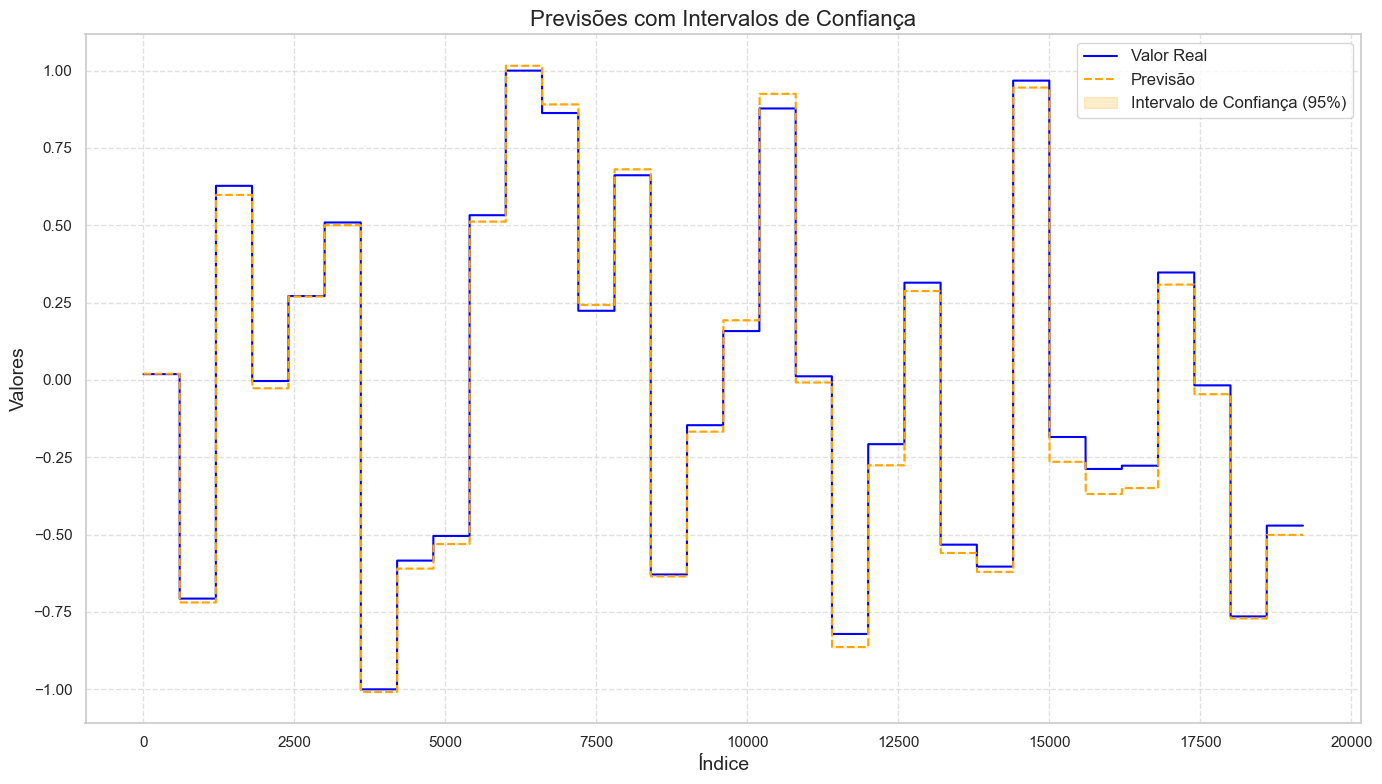

Epoch 100 | Train Loss: -2.2114217281341553 | Test Loss: -2.1870250034332277 | Variance: 5.500854220914786e-13
Epoch 101 | Train Loss: -2.20768404006958 | Test Loss: -2.1870250034332277 | Variance: 5.053466868056022e-13
Epoch 102 | Train Loss: -2.187831401824951 | Test Loss: -2.1870250034332277 | Variance: 4.126455850194527e-13
Epoch 103 | Train Loss: -2.292604923248291 | Test Loss: -2.1870250034332277 | Variance: 4.1392258544326044e-13
Epoch 104 | Train Loss: -2.2920737266540527 | Test Loss: -2.1870250034332277 | Variance: 3.8259667786352813e-13
Epoch 105 | Train Loss: -2.3004465103149414 | Test Loss: -2.1870250034332277 | Variance: 3.4271318964142206e-13
Epoch 106 | Train Loss: -2.3021082878112793 | Test Loss: -2.1870250034332277 | Variance: 3.0794060335535833e-13
Epoch 107 | Train Loss: -2.302344560623169 | Test Loss: -2.1870250034332277 | Variance: 2.7561156482058813e-13
Epoch 108 | Train Loss: -2.30229115486145 | Test Loss: -2.1870250034332277 | Variance: 2.5929733078570993e-13
Ep

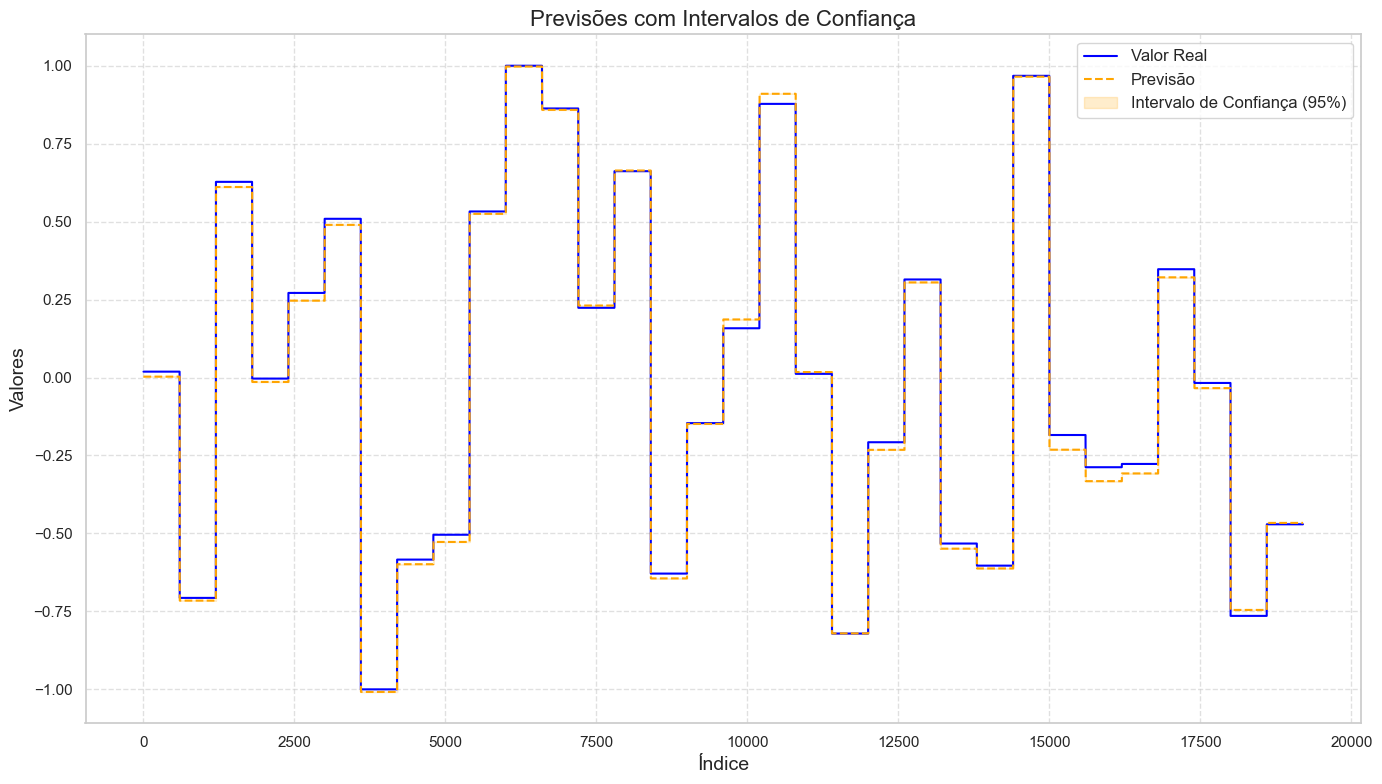

Epoch 110 | Train Loss: -2.3022143840789795 | Test Loss: -2.120528274377187 | Variance: 2.797180076539313e-13
Epoch 111 | Train Loss: -2.3000826835632324 | Test Loss: -2.120528274377187 | Variance: 2.96164975139776e-13
Epoch 112 | Train Loss: -2.3016324043273926 | Test Loss: -2.120528274377187 | Variance: 4.0745315108003943e-13
Epoch 113 | Train Loss: -2.20770263671875 | Test Loss: -2.120528274377187 | Variance: 4.1767050972321695e-13
Epoch 114 | Train Loss: -2.280397415161133 | Test Loss: -2.120528274377187 | Variance: 2.5388404486376137e-13
Epoch 115 | Train Loss: -2.257233142852783 | Test Loss: -2.120528274377187 | Variance: 2.9487249772995605e-13
Epoch 116 | Train Loss: -2.2930939197540283 | Test Loss: -2.120528274377187 | Variance: 2.7004367166884313e-13
Epoch 117 | Train Loss: -2.301539182662964 | Test Loss: -2.120528274377187 | Variance: 2.205800917354922e-13
Epoch 118 | Train Loss: -2.234304428100586 | Test Loss: -2.120528274377187 | Variance: 2.2995632633325547e-13
Epoch 119 |

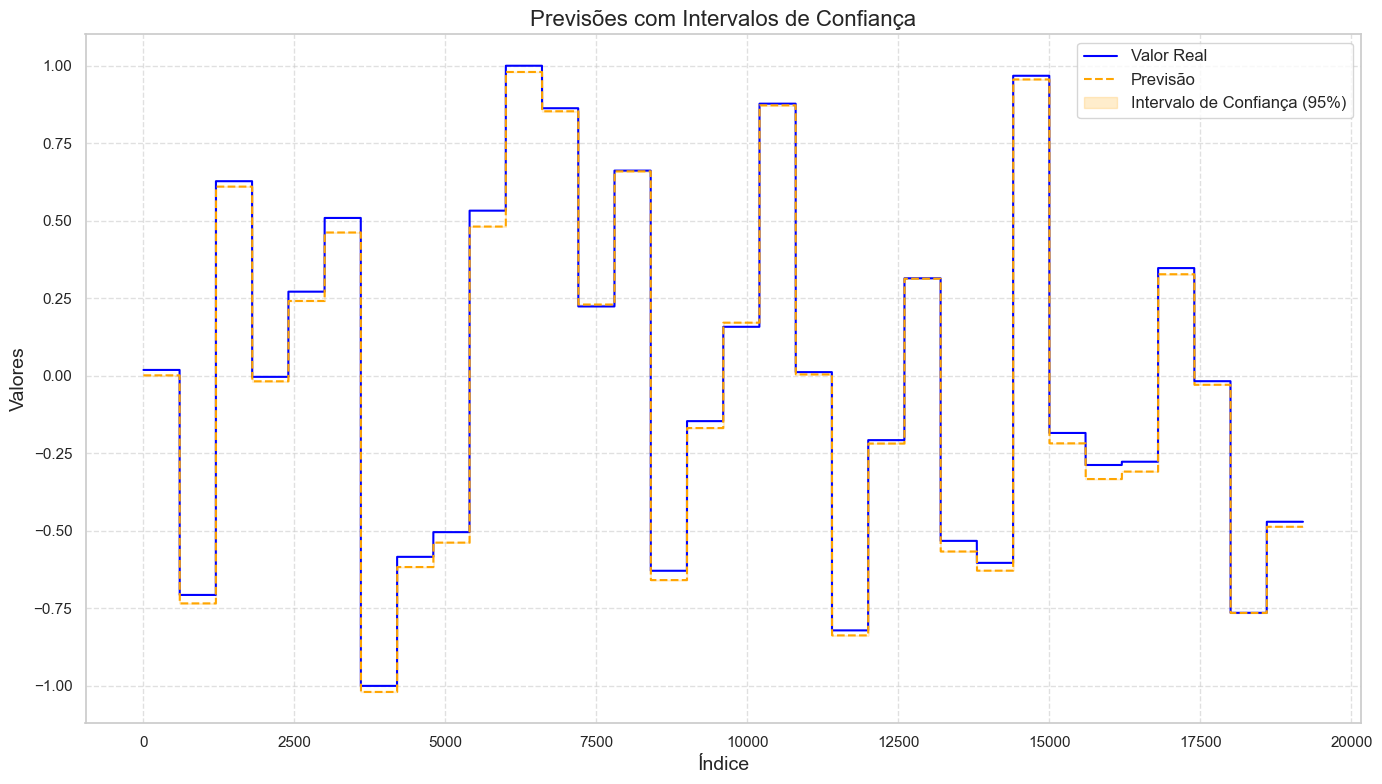

BEST MODEL
Epoch 120 | Train Loss: -2.283095598220825 | Test Loss: -2.1961347218354543 | Variance: 2.0736075345955535e-13
Epoch 121 | Train Loss: -2.2759604454040527 | Test Loss: -2.1961347218354543 | Variance: 2.1006029489629985e-13
Epoch 122 | Train Loss: -2.2643628120422363 | Test Loss: -2.1961347218354543 | Variance: 1.8175238603642535e-13
Epoch 123 | Train Loss: -2.2265329360961914 | Test Loss: -2.1961347218354543 | Variance: 1.9207752792807509e-13
Epoch 124 | Train Loss: -2.287712335586548 | Test Loss: -2.1961347218354543 | Variance: 1.668079736838468e-13
Epoch 125 | Train Loss: -2.299550771713257 | Test Loss: -2.1961347218354543 | Variance: 1.4844393346914037e-13
Epoch 126 | Train Loss: -1.9463224411010742 | Test Loss: -2.1961347218354543 | Variance: 2.688548439867128e-13
Epoch 127 | Train Loss: -2.2585573196411133 | Test Loss: -2.1961347218354543 | Variance: 2.111946414192628e-13
Epoch 128 | Train Loss: -2.2462079524993896 | Test Loss: -2.1961347218354543 | Variance: 1.73045944

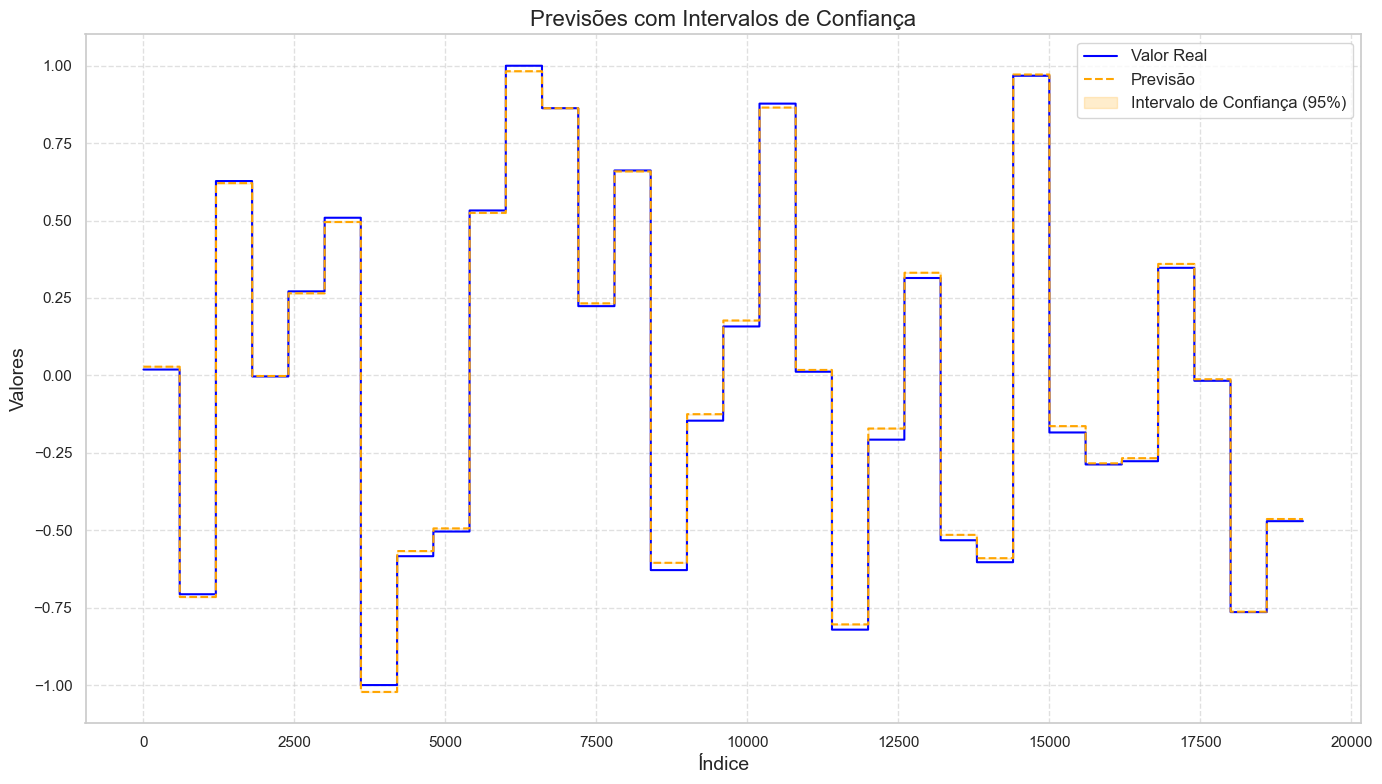

Epoch 130 | Train Loss: -2.298879861831665 | Test Loss: -2.096884300708771 | Variance: 1.5202471443168109e-13
Epoch 131 | Train Loss: -2.3023123741149902 | Test Loss: -2.096884300708771 | Variance: 1.4261846098626713e-13
Epoch 132 | Train Loss: -2.3024723529815674 | Test Loss: -2.096884300708771 | Variance: 1.3280648553538194e-13
Epoch 133 | Train Loss: -2.3018240928649902 | Test Loss: -2.096884300708771 | Variance: 1.275198886372883e-13
Epoch 134 | Train Loss: -2.3012661933898926 | Test Loss: -2.096884300708771 | Variance: 1.208545931516078e-13
Epoch 135 | Train Loss: -2.301574468612671 | Test Loss: -2.096884300708771 | Variance: 1.1428812269394933e-13
Epoch 136 | Train Loss: -2.3016200065612793 | Test Loss: -2.096884300708771 | Variance: 1.071688243248041e-13
Epoch 137 | Train Loss: -2.3021841049194336 | Test Loss: -2.096884300708771 | Variance: 9.736081976437563e-14
Epoch 138 | Train Loss: -2.30242919921875 | Test Loss: -2.096884300708771 | Variance: 9.029302099842346e-14
Epoch 139 

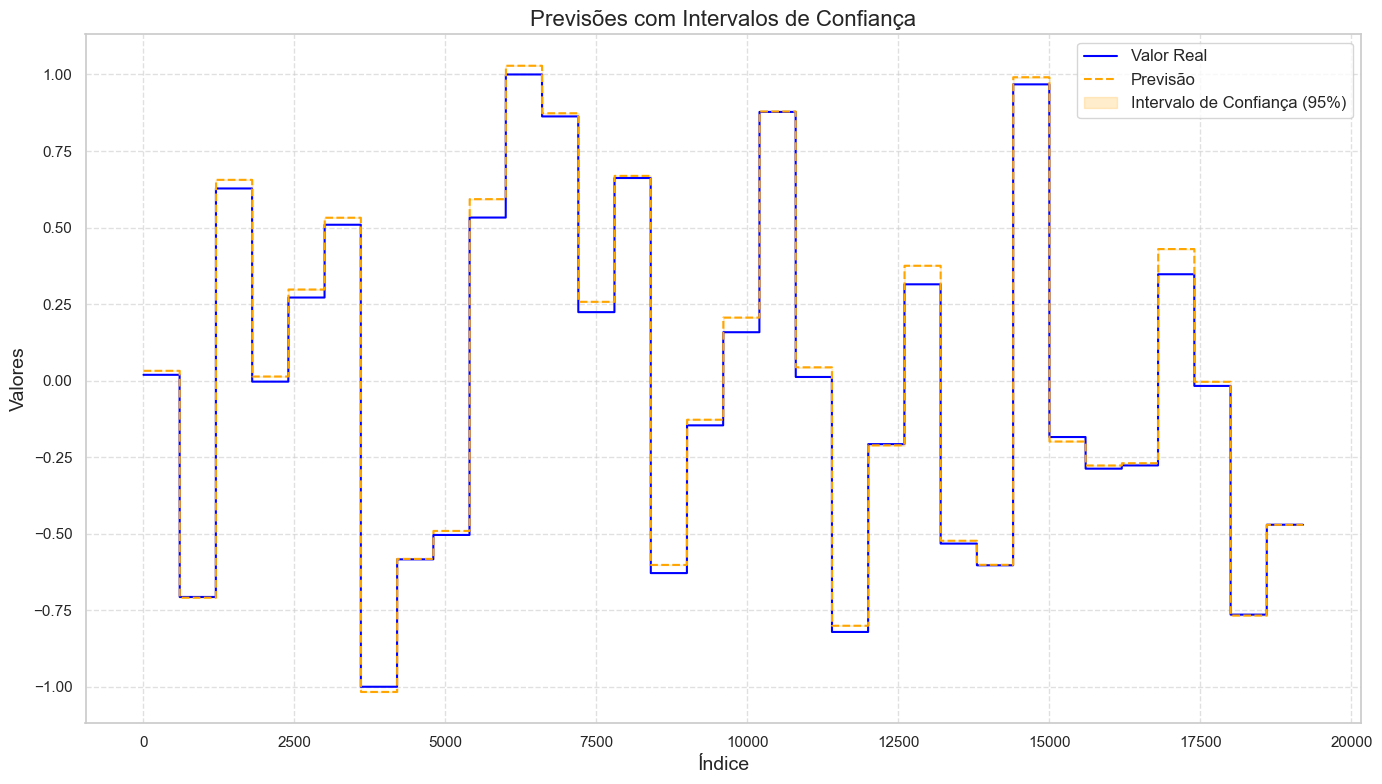

Epoch 140 | Train Loss: -2.3023080825805664 | Test Loss: -2.0539576880137127 | Variance: 8.014414327496555e-14
Epoch 141 | Train Loss: -2.300912380218506 | Test Loss: -2.0539576880137127 | Variance: 7.740807777753544e-14
Epoch 142 | Train Loss: -2.3009488582611084 | Test Loss: -2.0539576880137127 | Variance: 8.316584861100054e-14
Epoch 143 | Train Loss: -2.2995951175689697 | Test Loss: -2.0539576880137127 | Variance: 1.2111797296435883e-13
Epoch 144 | Train Loss: -2.288090944290161 | Test Loss: -2.0539576880137127 | Variance: 8.931339012547418e-14
Epoch 145 | Train Loss: -2.296274423599243 | Test Loss: -2.0539576880137127 | Variance: 1.144793352995943e-13
Epoch 146 | Train Loss: -2.295254707336426 | Test Loss: -2.0539576880137127 | Variance: 9.693339338666396e-14
Epoch 147 | Train Loss: -2.30061411857605 | Test Loss: -2.0539576880137127 | Variance: 1.146850762143506e-13
Epoch 148 | Train Loss: -2.293036460876465 | Test Loss: -2.0539576880137127 | Variance: 9.907829764954634e-14
Epoch 1

In [ ]:
test_losses = []
val_losses = []
best_loss = float('inf')

model.train()
for epoch in range(n_epochs):
    # Loop de treinamento
    for batch in train_loader:
        x = batch[0]
        y = batch[1]
        optimizer.zero_grad()
        mu, var = model(x)
        loss = criterion(mu, y, var)
        loss.backward()
        optimizer.step()

    # Test loop
    if epoch % 10 == 0:
        model.eval()
        all_test_losses = []
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0]
                y = batch[1]
                mu, var = model(x)
                all_test_losses.append(criterion(mu, y, var).item())
        test_loss = sum(all_test_losses) / len(all_test_losses)
        test_losses.append(test_loss)
        make_plot(model, X_train_tensor, y_train_tensor)
    # Validação
    model.eval()
    with torch.no_grad():
        batch_val_losses = []
        for X_val, y_val in test_loader:
            mu, var = model(X_val)
            batch_val_losses.append(criterion(mu, y_val, var).item())
        val_loss = np.mean(batch_val_losses)
        val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        print("BEST MODEL")
        best_model = model.state_dict()

    # Log
    print(f"Epoch {epoch} | Train Loss: {loss.item()} | Test Loss: {test_loss} | Variance: {var.mean().item()}")


In [104]:
# Carregar o melhor modelo salvo
model.eval()


LSTMModel(
  (lstm): LSTM(4, 104, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3394633936788146, inplace=False)
  (activation): Tanh()
  (fc1): Linear(in_features=208, out_features=104, bias=True)
  (fc2): Linear(in_features=104, out_features=52, bias=True)
  (fc3): Linear(in_features=52, out_features=52, bias=True)
  (fc4): Linear(in_features=52, out_features=2, bias=True)
  (mu): Linear(in_features=2, out_features=2, bias=True)
  (var): Linear(in_features=2, out_features=2, bias=True)
)

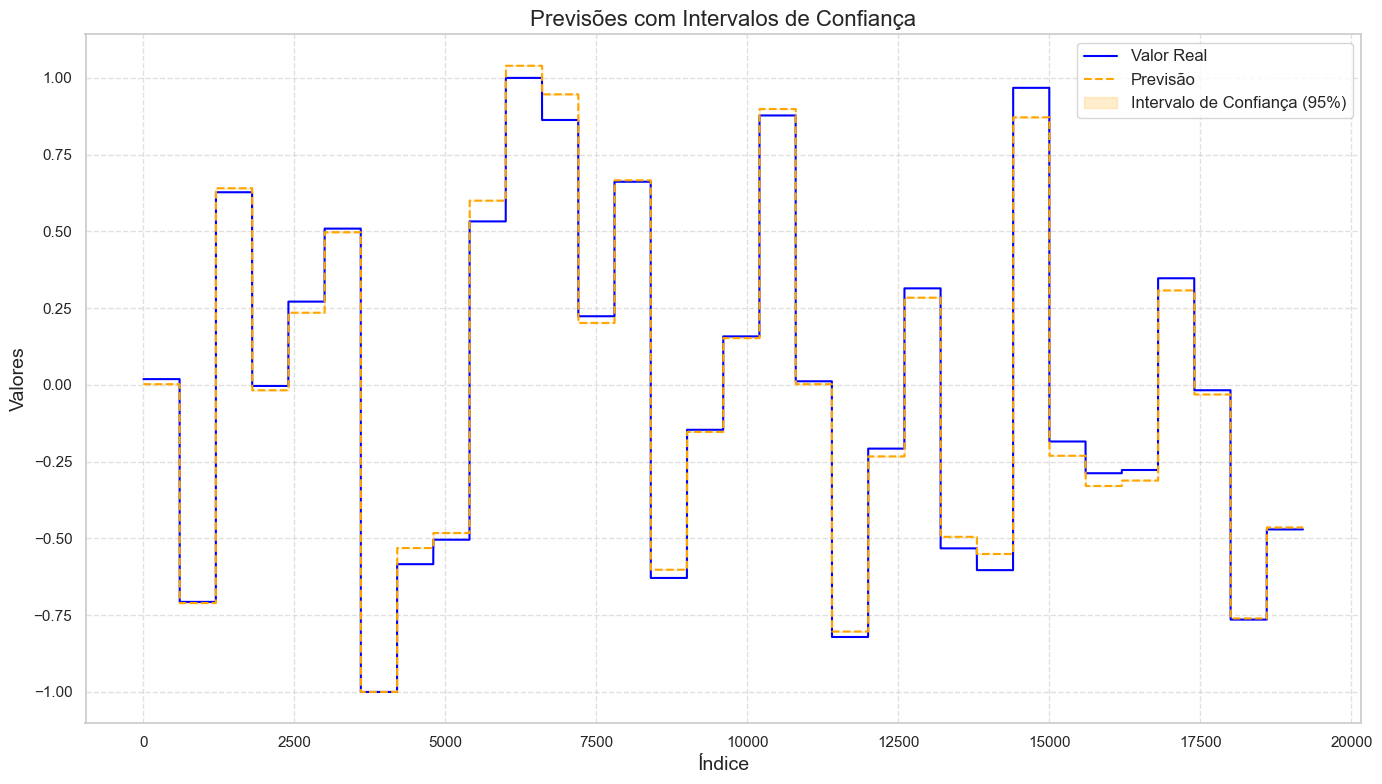

In [105]:

model.load_state_dict(best_model)
make_plot(model, X_train_tensor, y_train_tensor)

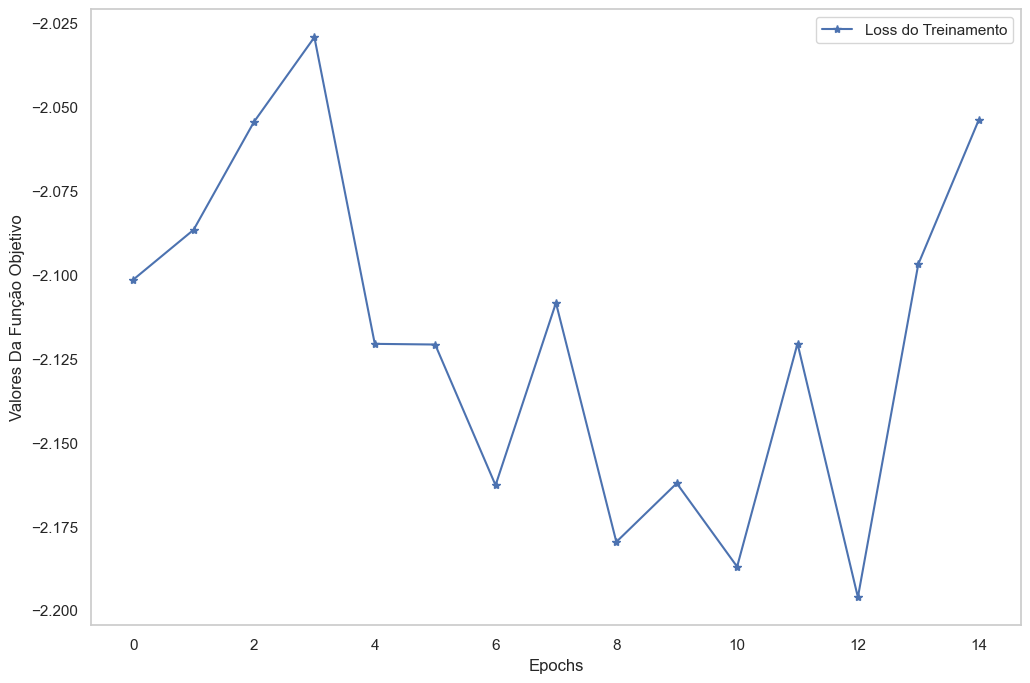

In [106]:
plt.plot(test_losses, marker="*", label='Loss do Treinamento')
#plt.plot(val_losses, label='Loss de Validação')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Valores Da Função Objetivo')
plt.grid()
plt.show()

In [107]:
# Carregar o melhor modelo salvo

#model.load_state_dict(model)
tempos = []

# Avaliação final com o conjunto de teste
model.eval()
with torch.no_grad():

    for i in range (10000):
        start = time.time()
        y_test_pred, var  = model(X_test_tensor)
        end = time.time()
        print(f"Tempo de execução: {end - start} segundos")
        test_loss = criterion(y_test_pred, y_test_tensor, var)
        tempo = end - start
        tempos.append(tempo)
        #print(f"Teste Loss: {test_loss.item()}")


Tempo de execução: 0.3018500804901123 segundos
Tempo de execução: 0.25580906867980957 segundos
Tempo de execução: 0.3314189910888672 segundos
Tempo de execução: 0.2778446674346924 segundos
Tempo de execução: 0.26973724365234375 segundos
Tempo de execução: 0.23295164108276367 segundos
Tempo de execução: 0.20219802856445312 segundos
Tempo de execução: 0.18309760093688965 segundos
Tempo de execução: 0.1816694736480713 segundos
Tempo de execução: 0.20402169227600098 segundos
Tempo de execução: 0.19811558723449707 segundos
Tempo de execução: 0.1807389259338379 segundos
Tempo de execução: 0.21312260627746582 segundos
Tempo de execução: 0.1975870132446289 segundos
Tempo de execução: 0.20136308670043945 segundos
Tempo de execução: 0.1860182285308838 segundos
Tempo de execução: 0.19661188125610352 segundos
Tempo de execução: 0.18750309944152832 segundos
Tempo de execução: 0.19620442390441895 segundos


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
default_dpi = 96
time_x = np.arange(len(tempos))
tempos = tempos
print(tempos)
def save_or_show(filename: str | None = None):
    if filename is None:
        plt.show()
    else:
        plt.savefig(save_folder + filename)
        plt.clf()
        plt.close()

[0.5665907859802246, 0.442324161529541, 0.33379411697387695, 0.34444451332092285, 0.33178210258483887, 0.33348846435546875, 0.34149789810180664, 0.3169066905975342, 0.3334500789642334, 0.33333420753479004, 0.34474992752075195, 0.34610724449157715]


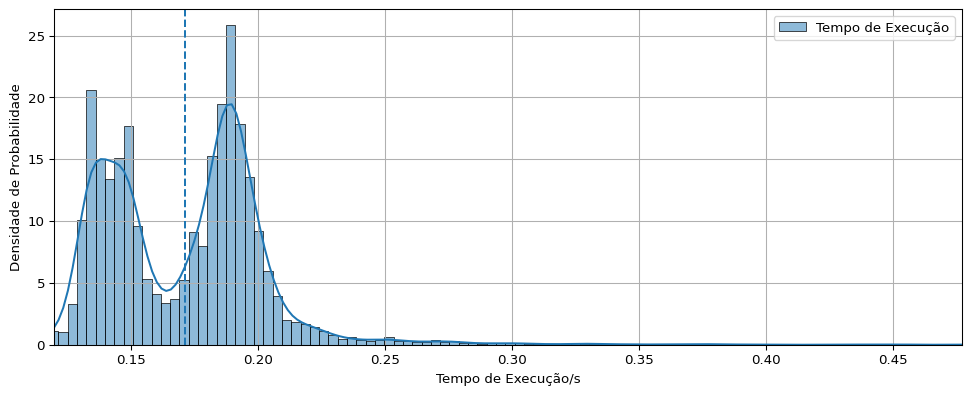

In [ ]:
def plot_density(values, labels, metric, filename: str | None = None):
    plt.figure(figsize=(10, 4), layout="constrained", dpi=default_dpi)
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
    for i in range(len(values)):
        sns.histplot(
            values[i],
            kde=True,
            label=labels[i],
            stat="density",
            bins=100,
            color=colors[i],
        )

        mean_value = np.mean(values[i])
        plt.axvline(
            mean_value,
            linestyle="--",
            linewidth=1.5,
            color=colors[i],
        )

    plt.xlabel(metric)
    plt.xlim(0.12, max(values[0]))
    plt.ylabel("Densidade de Probabilidade")
    plt.grid()
    plt.legend()

plot_density([tempos], ["Tempo de Execução"], "Tempo de Execução/s")

Tempo de execução: 0.34700560569763184 segundos
tensor([[5.2373e-09, 3.8952e-10],
        [5.7318e-09, 4.3171e-10],
        [5.7318e-09, 4.3171e-10],
        ...,
        [5.0883e-13, 1.0505e-14],
        [5.0883e-13, 1.0505e-14],
        [5.0883e-13, 1.0505e-14]])


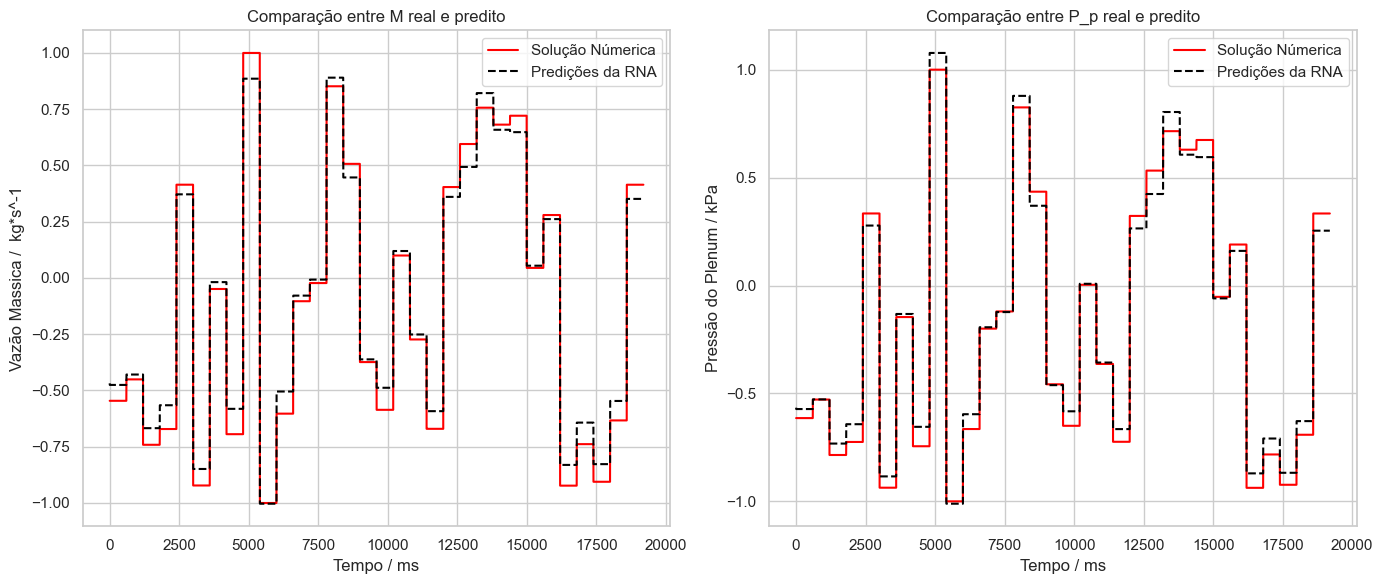

In [108]:


with torch.no_grad():

    
    start = time.time()
    y_test_pred, var = model(X_test_tensor)
    end = time.time()
    print(f"Tempo de execução: {end - start} segundos")
    test_loss = criterion(y_test_pred, y_test_tensor, var)
    

print(var)
y_test_pred_original = y_test_pred
y_test_original = y_test



plt.figure(figsize=(14, 6))

# Plot para M (Mass Flow Rate)
plt.subplot(1, 2, 1)
plt.plot(y_test_original[:, 0], label="Solução Númerica", color="red")
plt.plot(y_test_pred_original[:, 0], "--", label="Predições da RNA", color="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Vazão Massica /  kg*s^-1')
plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.subplot(1, 2, 2)
plt.plot(y_test_original[:, 1], label="Solução Númerica" ,color="red")
plt.plot(y_test_pred_original[:, 1], "--", label="Predições da RNA", color="black")
plt.xlabel('Tempo / ms')
plt.ylabel('Pressão do Plenum / kPa')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()


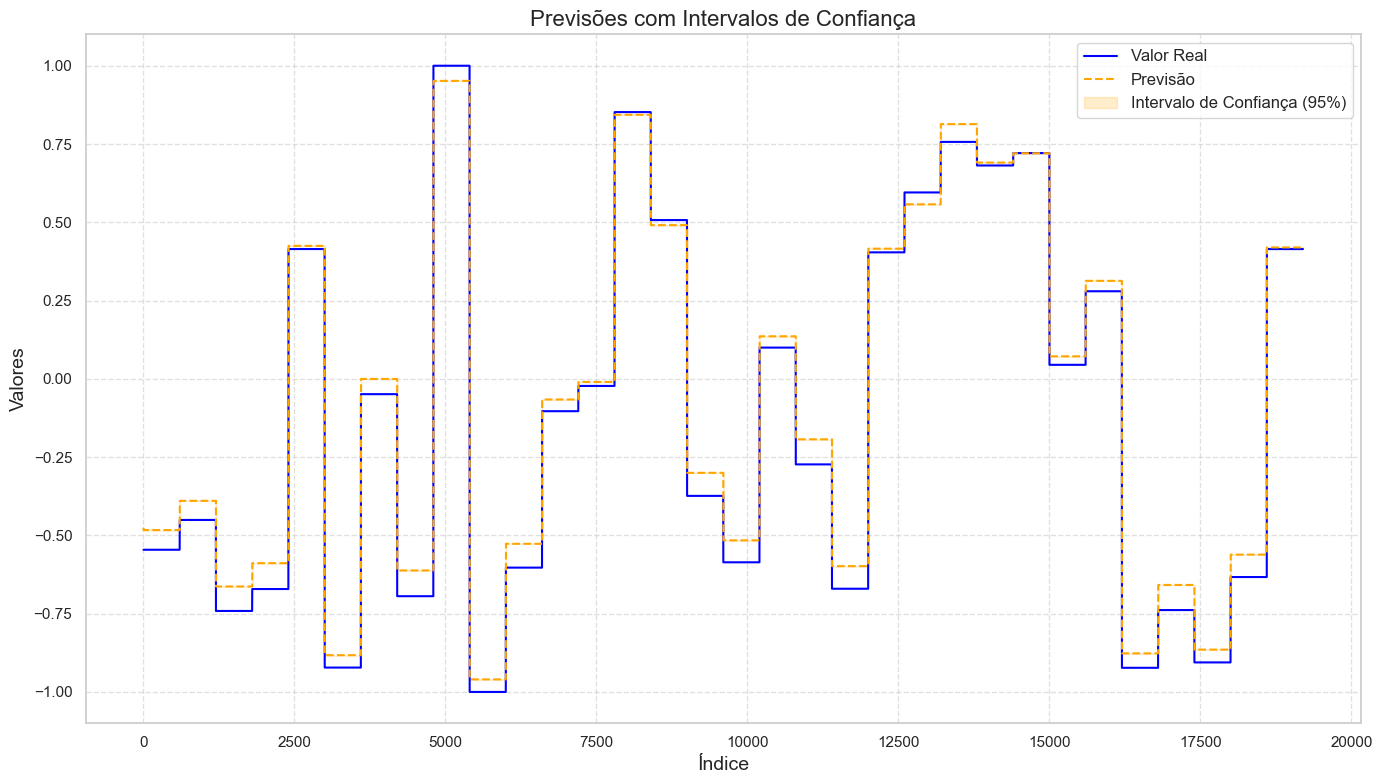

In [90]:
make_plot(model, X_test_tensor, y_test_tensor)

